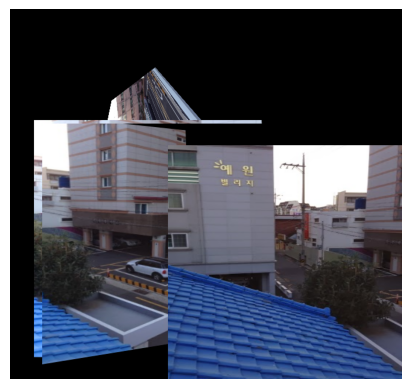

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Rutas de las imágenes
    image_paths = [
        "pictures/S1.jpg",
        "pictures/S2.jpg",
        "pictures/S3.jpg",
        "pictures/S4.jpg",
        "pictures/S5.jpg"
        # Agrega más rutas según sea necesario
    ]

    # Cargar las imágenes y redimensionarlas
    images = [cv2.resize(cv2.imread(path), (400, 400)) for path in image_paths]

    # Realizar la panorámica
    result = stitch_panorama(images)

    # Mostrar la panorámica resultante
    if result is not None:
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("No se pudo crear la panorámica")

def stitch_panorama(images, ratio=0.9, reproj_thresh=2.0):
    num_images = len(images)
    if num_images < 2:
        print("Se necesitan al menos dos imágenes para crear una panorámica")
        return None

    # Inicializar la imagen panorámica
    result = images[0]

    # Iterar sobre las imágenes restantes para agregarlas a la panorámica
    for i in range(1, num_images):
        result = stitch_images(result, images[i], ratio, reproj_thresh)
        if result is None:
            print(f"No se pudo unir la imagen {i+1} a la panorámica")
            return None

    return result
def stitch_images(img1, img2, ratio=0.9, reproj_thresh=2.0):
    # Detectar keypoints y descriptores en las imágenes
    keypoints1, descriptors1 = detect_keypoints_and_descriptors(img1)
    keypoints2, descriptors2 = detect_keypoints_and_descriptors(img2)

    # Coincidir keypoints usando el emparejador Brute Force
    matches = match_keypoints(descriptors1, descriptors2)

    # Aplicar el test de ratio
    good_matches = apply_ratio_test(matches, ratio)

    if len(good_matches) < 4:
        return None

    # Extraer los keypoints coincidentes
    src_pts, dst_pts = extract_matched_keypoints(good_matches, keypoints1, keypoints2)

    # Encontrar la homografía
    homography, mask = find_homography(src_pts, dst_pts, reproj_thresh)

    # Determinar las esquinas de la imagen alineada
    h, w = img1.shape[:2]
    corners = np.array([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]], dtype=np.float32)
    corners = np.array([corners])

    # Transformar las esquinas de la imagen alineada
    corners_transformed = cv2.perspectiveTransform(corners, homography)

    # Ajustar la imagen alineada al tamaño de la panorámica
    x_offset = min(corners_transformed[0, :, 0])
    y_offset = min(corners_transformed[0, :, 1])
    x_offset = int(min(0, x_offset))
    y_offset = int(min(0, y_offset))

    img2_aligned = cv2.warpPerspective(img2, homography, (img1.shape[1] + abs(x_offset), img1.shape[0] + abs(y_offset)))
    img2_aligned[-y_offset:img1.shape[0] - y_offset, -x_offset:img1.shape[1] - x_offset] = img1

    return img2_aligned


def detect_keypoints_and_descriptors(image):
    orb = cv2.ORB_create(nfeatures=1000)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

def match_keypoints(descriptors1, descriptors2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    return matches

def apply_ratio_test(matches, ratio):
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    return good_matches

def extract_matched_keypoints(matches, keypoints1, keypoints2):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    return src_pts, dst_pts

def find_homography(src_pts, dst_pts, reproj_thresh):
    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, reproj_thresh)
    return homography, mask

if __name__ == "__main__":
    main()
